##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title ##### Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Variational Autoencoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/python/experimental/nn/examples/vae_mnist_advi.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/experimental/nn/examples/vae_mnist_advi.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### 1  Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

# Globally Enable XLA.
# tf.config.optimizer.set_jit(True)

try:
  physical_devices = tf.config.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

tfb = tfp.bijectors
tfd = tfp.distributions
tfn = tfp.experimental.nn

### 2  Load Dataset

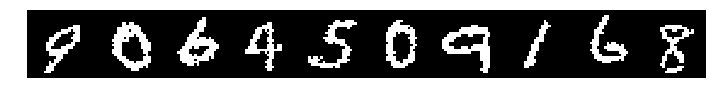

In [0]:
[train_dataset, eval_dataset], datasets_info = tfds.load(
    name='binarized_mnist',
    split=['train', 'test'],
    with_info=True,
    shuffle_files=True)

def _preprocess(sample):
  return tf.cast(sample['image'], tf.float32)

train_size = datasets_info.splits['train'].num_examples
batch_size = 32

train_dataset = tfn.util.tune_dataset(
    train_dataset,
    batch_size=batch_size,
    shuffle_size=int(train_size  / 7),
    preprocess_fn=_preprocess)

eval_dataset = tfn.util.tune_dataset(
    eval_dataset,
    repeat_count=1,
    preprocess_fn=_preprocess)

x = next(iter(eval_dataset.batch(10)))
tfn.util.display_imgs(x);

### 3  Define Model

In [0]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

In [0]:
prior = tfd.Sample(tfd.Normal(loc=0, scale=1), sample_shape=encoded_size)

In [0]:
Conv = functools.partial(
    tfn.Convolution,
    init_kernel_fn=tf.initializers.he_uniform())  # Better for leaky_relu.

encoder = tfn.Sequential([
    lambda x: 2. * tf.cast(x, tf.float32) - 1.,
    Conv(1, 1 * base_depth, 5, strides=1, padding='same'),
    tf.nn.leaky_relu,
    Conv(1 * base_depth, 1 * base_depth, 5, strides=2, padding='same'),
    tf.nn.leaky_relu,
    Conv(1 * base_depth, 2 * base_depth, 5, strides=1, padding='same'),
    tf.nn.leaky_relu,
    Conv(2 * base_depth, 2 * base_depth, 5, strides=2, padding='same'),
    tf.nn.leaky_relu,
    Conv(2 * base_depth, 4 * encoded_size, 7, strides=1, padding='valid'),
    tf.nn.leaky_relu,
    tfn.util.flatten_rightmost(ndims=3),
    tfn.Affine(64, encoded_size + encoded_size * (encoded_size + 1) // 2),
    lambda x: tfd.MultivariateNormalTriL(
        loc=x[..., :encoded_size],
        scale_tril=tfb.FillScaleTriL()(x[..., encoded_size:]))
], name='encoder')

print(encoder.summary())

=== encoder ==================================================
  SIZE SHAPE                TRAIN NAME                                    
    32 [32]                 True  bias:0                                  
   800 [5, 5, 1, 32]        True  kernel:0                                
    32 [32]                 True  bias:0                                  
 25600 [5, 5, 32, 32]       True  kernel:0                                
    64 [64]                 True  bias:0                                  
 51200 [5, 5, 32, 64]       True  kernel:0                                
    64 [64]                 True  bias:0                                  
102400 [5, 5, 64, 64]       True  kernel:0                                
    64 [64]                 True  bias:0                                  
200704 [7, 7, 64, 64]       True  kernel:0                                
   152 [152]                True  bias:0                                  
  9728 [64, 152]            True  ker

In [0]:
DeConv = functools.partial(
    tfn.ConvolutionTranspose,
    init_kernel_fn=tf.initializers.he_uniform())  # Better for leaky_relu.
    
decoder = tfn.Sequential([
    lambda x: x[..., tf.newaxis, tf.newaxis, :],
    DeConv(encoded_size, 2 * base_depth, 7, strides=1, padding='valid'),
    tf.nn.leaky_relu,
    DeConv(2 * base_depth, 2 * base_depth, 5, strides=1, padding='same'),
    tf.nn.leaky_relu,
    DeConv(2 * base_depth, 2 * base_depth, 5, strides=2, padding='same'),
    tf.nn.leaky_relu,
    DeConv(2 * base_depth, base_depth, 5, strides=1, padding='same'),
    tf.nn.leaky_relu,
    DeConv(1 * base_depth, 1 * base_depth, 5, strides=2, padding='same'),
    tf.nn.leaky_relu,
    DeConv(1 * base_depth, 1 * base_depth, 5, strides=1, padding='same'),
    tf.nn.leaky_relu,
    Conv(1 * base_depth, 1, 5, strides=1, padding='same'),
    tfn.util.flatten_rightmost(ndims=3),
    tfb.Reshape(input_shape),
    lambda x: tfd.Independent(tfd.Bernoulli(logits=x),
                              reinterpreted_batch_ndims=len(input_shape)),
], name='decoder')

print(decoder.summary())

=== decoder ==================================================
  SIZE SHAPE                TRAIN NAME                                    
    64 [64]                 True  bias:0                                  
 50176 [7, 7, 64, 16]       True  kernel:0                                
    64 [64]                 True  bias:0                                  
102400 [5, 5, 64, 64]       True  kernel:0                                
    64 [64]                 True  bias:0                                  
102400 [5, 5, 64, 64]       True  kernel:0                                
    32 [32]                 True  bias:0                                  
 51200 [5, 5, 32, 64]       True  kernel:0                                
    32 [32]                 True  bias:0                                  
 25600 [5, 5, 32, 32]       True  kernel:0                                
    32 [32]                 True  bias:0                                  
 25600 [5, 5, 32, 32]       True  ker

### 4  Train

In [0]:
train_iter = iter(train_dataset)
eval_iter = iter(eval_dataset.batch(2000).repeat())

def compute_loss(x, beta=1.):
  q = encoder(x)
  z = q.sample()
  p = decoder(z)
  kl = tf.reduce_mean(q.log_prob(z) - prior.log_prob(z), axis=-1)
  # Note: you could use exact KL divergence, eg:
  #   kl = tf.reduce_mean(tfd.kl_divergence(q, prior))
  # however we generally find that using the Monte Carlo approximation has
  # lower variance.
  nll = -tf.reduce_mean(p.log_prob(x), axis=-1)
  return nll + beta * kl, (nll, kl)

def loss():
  x = next(train_iter)
  return compute_loss(x)

opt = tf.optimizers.Adam(learning_rate=1e-3)

_DEBUG = False

fit = tfn.util.make_fit_op(
    loss,
    opt,
    decoder.trainable_variables + encoder.trainable_variables,
    grad_summary_fn=lambda gs: tf.nest.map_structure(tf.norm, gs),
    tf_function=not(_DEBUG),
    xla_compile=not(_DEBUG))

@tfn.util.tfcompile(tf_function=not(_DEBUG), xla_best_effort=not(_DEBUG))
def eval():
  x = next(eval_iter)
  return compute_loss(x)

In [0]:
num_train_steps = 10e3  # @param { isTemplate: true}
num_train_steps = int(num_train_steps)  # Enforce correct type when overridden.
dur_sec = dur_num = 0

for i in range(num_train_steps):
  start = time.time()
  trn_loss, (trn_nll, trn_kl), g = fit()
  stop = time.time()
  dur_sec += stop - start
  dur_num += 1
  if i % 100 == 0 or i == num_train_steps - 1:
    tst_loss, (tst_nll, tst_kl) = eval()
    f, x = zip(*[
        ('it:{:5}', opt.iterations),
        ('ms/it:{:6.4f}', dur_sec / max(1., dur_num) * 1000.),
        ('trn_loss:{:6.4f}', trn_loss),
        ('tst_loss:{:6.4f}', tst_loss),
        ('tst_nll:{:6.4f}', tst_nll),
        ('tst_kl:{:6.4f}', tst_kl),
        ('sum_norm_grad:{:6.4f}', sum(g)),

    ])
    print('   '.join(f).format(*[getattr(x_, 'numpy', lambda: x_)()
                                 for x_ in x]))
    sys.stdout.flush()
    dur_sec = dur_num = 0
  # if i % 1000 == 0 or i == maxiter - 1:
  #   encoder.save('/tmp/encoder.npz')
  #   decoder.save('/tmp/decoder.npz')

it:    1   ms/it:6596.1990   trn_loss:616.3754   tst_loss:555.1830   tst_nll:521.3077   tst_kl:33.8753   sum_norm_grad:4361.0889
it:  101   ms/it:7.7264   trn_loss:212.0488   tst_loss:197.8180   tst_nll:193.8511   tst_kl:3.9669   sum_norm_grad:1313.3070
it:  201   ms/it:7.7170   trn_loss:177.5913   tst_loss:171.9726   tst_nll:164.8396   tst_kl:7.1330   sum_norm_grad:608.7997
it:  301   ms/it:7.6904   trn_loss:162.2127   tst_loss:157.7156   tst_nll:148.7812   tst_kl:8.9345   sum_norm_grad:426.5427
it:  401   ms/it:7.7482   trn_loss:159.7486   tst_loss:148.8958   tst_nll:138.4932   tst_kl:10.4026   sum_norm_grad:472.2920
it:  501   ms/it:7.7882   trn_loss:152.1020   tst_loss:145.6450   tst_nll:135.0408   tst_kl:10.6042   sum_norm_grad:776.1210
it:  601   ms/it:7.6834   trn_loss:129.7168   tst_loss:140.1515   tst_nll:128.9729   tst_kl:11.1785   sum_norm_grad:562.8702
it:  701   ms/it:7.7976   trn_loss:124.6419   tst_loss:138.9889   tst_nll:127.6702   tst_kl:11.3188   sum_norm_grad:625.039

### 5  Evaluate

In [0]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset.batch(10)))
xhat = decoder(encoder(x).sample())
assert isinstance(xhat, tfd.Distribution)

Originals:


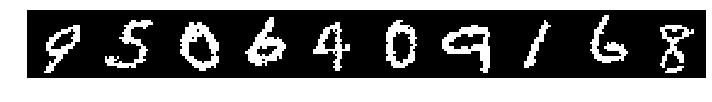

Decoded Random Samples:


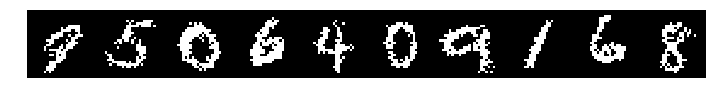

Decoded Modes:


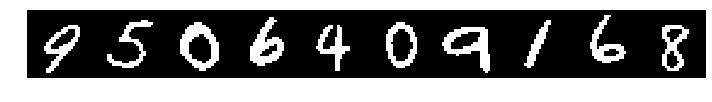

Decoded Means:


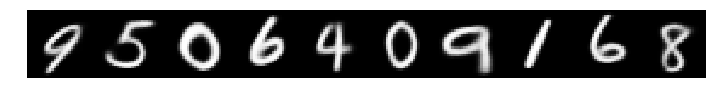

In [0]:
print('Originals:')
tfn.util.display_imgs(x);

print('Decoded Random Samples:')
tfn.util.display_imgs(xhat.sample());

print('Decoded Modes:')
tfn.util.display_imgs(xhat.mode());

print('Decoded Means:')
tfn.util.display_imgs(xhat.mean());